In [140]:
import numpy as np
import pandas as pd
import math

from scipy.optimize import minimize, Bounds, fmin_cg
from skopt import gp_minimize
from deap import base, creator, tools, algorithms
import random
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from matplotlib import pyplot as plt
import seaborn as sns

import yfinance as yf
import pandas_datareader as pdr
import pandas_market_calendars as mcal

import datetime

In [142]:
end_date = datetime.date.today()
start_date = end_date - datetime.timedelta(days=1800)
nyse = mcal.get_calendar('NYSE')
valid_dates = nyse.valid_days(start_date=start_date, end_date =end_date)
valid_start_day = valid_dates[0].date()
valid_end_day = valid_dates[-1].date()

#S&P 500 ticker
SnP_componet_ticker = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0].Symbol

def final_ticker(T_list):
    return list(set(T_list))

index_banch_mart = ["VOO"]

tickers = final_ticker(SnP_componet_ticker)

def get_stock_data(tickers_list, start_date, end_date=None):
    
    all_tickers = list(dict.fromkeys(tickers_list))
    
    data = yf.download(all_tickers, start=start_date, end=end_date)['Close']
    if isinstance(data, pd.DataFrame):
        data = data.dropna(axis=1)
        available_tickers = list(data.columns)
    else:
        available_tickers = all_tickers
    
    return data, available_tickers

def initialize_portfolio(tickers, equal_weight=True):
    n_assets = len(tickers)
    if equal_weight:
        weight = 1.0/n_assets
    else:
        weight = 1.0
        
    return {ticker: weight for ticker in tickers}

df,tickers = get_stock_data(tickers,valid_start_day)

df_BM,_ = get_stock_data(index_banch_mart, valid_start_day)
number_of_stocks = df.shape[1]

[*********************100%***********************]  503 of 503 completed

3 Failed downloads:
['BRK.B']: YFTzMissingError('possibly delisted; no timezone found')
['ETR', 'BF.B']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-03-19 -> 2025-02-21)')
[*********************100%***********************]  1 of 1 completed


In [143]:
def Get_rfr(start):
    risk_free_rate = pd.DataFrame()
    shifted_date = 0 # change this if you run this on a non-trading day, just in case
    while risk_free_rate.empty:
        risk_free_rate = pdr.DataReader('DGS3MO', 'fred', start).dropna()
        shifted_date += 1
    return risk_free_rate/100
rfr = Get_rfr(valid_start_day)

In [144]:
ret_df = np.log(df/df.shift(1)).dropna()
ret_df_BM = np.log(df_BM/df_BM.shift(1)).dropna()

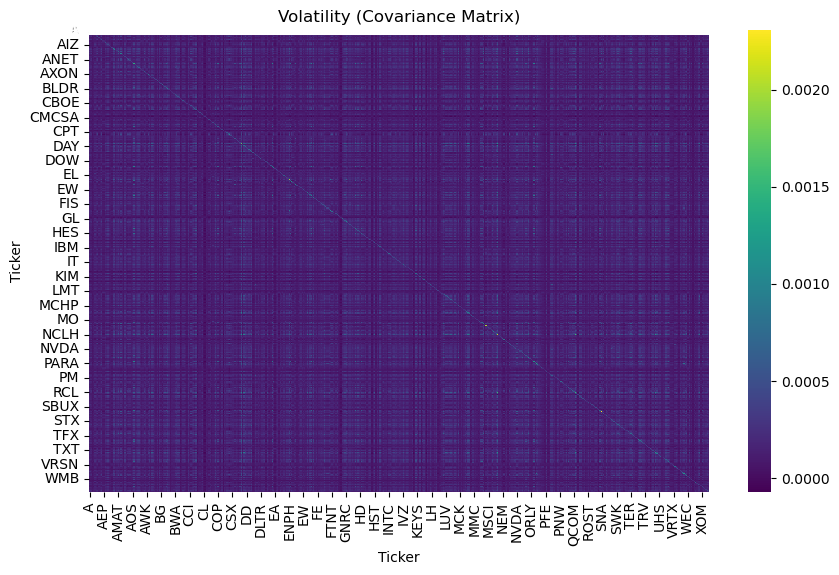

In [145]:
Covarian_matrix = ret_df.cov()
plt.figure(figsize=(10, 6))
sns.heatmap(Covarian_matrix, annot=True, cmap='viridis', fmt='.2e')
plt.title('Volatility (Covariance Matrix)')
plt.show()

## Strategy
1) Decompose SnP500 into principle componet
2) Pick the top 5 principle components with highest sharp ratio and make a portfolio out of it
3) Update every month, past window = 252 days, holding period = 21 days

In [147]:
def perform_pca_analysis(returns_df, variance_threshold=0.90):
    
    # Standardize the data
    scaler = StandardScaler()
    scaled_returns = scaler.fit_transform(returns_df)
    
    # Initialize PCA with all components
    pca = PCA()
    pca.fit(scaled_returns)
    
    # Find number of components needed for threshold
    cumsum = np.cumsum(pca.explained_variance_ratio_)
    n_components = np.argmax(cumsum >= variance_threshold) + 1
    
    # Perform PCA with determined number of components
    pca = PCA(n_components=n_components)
    principal_components = pca.fit_transform(scaled_returns)
    
    # Create DataFrame for principal components
    pc_df = pd.DataFrame(
        principal_components,
        columns=[f'PC{i+1}' for i in range(n_components)],
        index=returns_df.index
    )
    
    # Get component loadings
    loadings = pd.DataFrame(
        pca.components_.T,
        columns=[f'PC{i+1}' for i in range(n_components)],
        index=returns_df.columns
    )
    
    # Calculate explained variance ratios
    explained_variance_ratio = pd.Series(
        pca.explained_variance_ratio_,
        index=[f'PC{i+1}' for i in range(n_components)]
    )
    
    cumulative_variance_ratio = explained_variance_ratio.cumsum()
    
    return {
        'principal_components': pc_df,
        'loadings': loadings,
        'explained_variance_ratio': explained_variance_ratio,
        'cumulative_variance_ratio': cumulative_variance_ratio,
        'n_components': n_components
    }

# Use the function
pca_results = perform_pca_analysis(ret_df, variance_threshold=0.90)

# Display results
print(f"\nNumber of components needed to explain {90}% of variance: {pca_results['n_components']}")

print("\nExplained Variance Ratio:")
print(pca_results['explained_variance_ratio'])

print("\nCumulative Variance Ratio:")
print(pca_results['cumulative_variance_ratio'])


Number of components needed to explain 90% of variance: 189

Explained Variance Ratio:
PC1      0.351363
PC2      0.056942
PC3      0.051566
PC4      0.018899
PC5      0.016192
           ...   
PC185    0.000811
PC186    0.000795
PC187    0.000781
PC188    0.000773
PC189    0.000764
Length: 189, dtype: float64

Cumulative Variance Ratio:
PC1      0.351363
PC2      0.408305
PC3      0.459871
PC4      0.478770
PC5      0.494962
           ...   
PC185    0.895663
PC186    0.896458
PC187    0.897240
PC188    0.898012
PC189    0.898776
Length: 189, dtype: float64


We will try to use this strategy:
1) Do a PCA using the past 3 months data
2)  pick the top 5 PC with the highest sharp ratio, hold for 1 month
3)  repeat 1) and 2)

In [149]:
def calculate_returns(df, df_BM, rfr):
    """Calculate log returns for data and align risk-free rate"""
    ret_df = np.log(df/df.shift(1)).dropna()
    ret_BM = np.log(df_BM/df_BM.shift(1)).dropna()
    rfr_aligned = rfr.reindex(ret_df.index, method='ffill')
    return ret_df, ret_BM, rfr_aligned

def perform_pca_analysis(window_data, n_components):
    """Perform PCA and return results and loadings"""
    pca = PCA(n_components=min(len(window_data.columns), len(window_data)))
    pca_results = pca.fit_transform(window_data.values)
    
    pca_results = pd.DataFrame(pca_results,
                             index=window_data.index,
                             columns=[f'PC{i+1}' for i in range(pca_results.shape[1])])
    
    loadings = pd.DataFrame(pca.components_.T,
                          index=window_data.columns,
                          columns=pca_results.columns)
    
    return pca_results, loadings

def calculate_pc_performance(window_data, loadings, window_rfr):
    """Calculate performance metrics for each principal component"""
    pc_performance = pd.DataFrame(index=loadings.columns)
    
    for pc in loadings.columns:
        pc_returns = (window_data @ loadings[pc])
        simple_returns = np.exp(pc_returns) - 1
        annual_return = (1 + simple_returns.mean()) ** 252 - 1
        annual_vol = simple_returns.std() * np.sqrt(252)
        window_annual_rfr = window_rfr * 252
        pc_performance.loc[pc, 'Sharpe'] = (annual_return - window_annual_rfr) / annual_vol
    
    return pc_performance

def calculate_portfolio_weights(loadings, top_pcs):
    """Calculate portfolio weights based on selected PCs"""
    portfolio_weights = pd.Series(0.0, index=loadings.index)
    for pc in top_pcs:
        portfolio_weights += loadings[pc] / len(top_pcs)
    
    # Normalize weights to ensure they sum to 1
    portfolio_weights /= portfolio_weights.sum()
    return portfolio_weights

def calculate_performance_metrics(returns, benchmark_returns, rfr):
    """Calculate performance metrics for strategy and benchmark"""
    simple_returns = np.exp(returns) - 1
    cum_returns = (1 + simple_returns).cumprod()
    
    benchmark_simple_returns = np.exp(benchmark_returns) - 1
    benchmark_cum_returns = (1 + benchmark_simple_returns).cumprod()
    
    annual_return = (1 + simple_returns.mean()) ** 252 - 1
    annual_vol = simple_returns.std() * np.sqrt(252)
    sharpe = (annual_return - rfr) / annual_vol
    
    benchmark_annual_return = ((1 + benchmark_simple_returns.mean()) ** 252 - 1).values[0]
    benchmark_annual_vol = (benchmark_simple_returns.std() * np.sqrt(252)).values[0]
    benchmark_sharpe = (benchmark_annual_return - rfr) / benchmark_annual_vol
    
    return {
        'strategy': {
            'returns': simple_returns,
            'cum_returns': cum_returns,
            'annual_return': annual_return,
            'annual_vol': annual_vol,
            'sharpe': sharpe
        },
        'benchmark': {
            'returns': benchmark_simple_returns,
            'cum_returns': benchmark_cum_returns,
            'annual_return': benchmark_annual_return,
            'annual_vol': benchmark_annual_vol,
            'sharpe': benchmark_sharpe
        }
    }

def plot_results(strategy_metrics, benchmark_metrics):
    """Plot strategy and benchmark results"""
    fig, ax = plt.subplots(figsize=(15, 8))
    
    ax.plot(strategy_metrics['cum_returns'].index, strategy_metrics['cum_returns'], 
            label=f'Strategy (Sharpe: {strategy_metrics["sharpe"]:.2f})')
    ax.plot(benchmark_metrics['cum_returns'].index, benchmark_metrics['cum_returns'], 
            label=f'Benchmark (Sharpe: {benchmark_metrics["sharpe"]:.2f})',
            linestyle='--')
    
    ax.set_title('Rolling PCA Strategy vs Benchmark')
    ax.set_xlabel('Date')
    ax.set_ylabel('Cumulative Return')
    ax.legend()
    ax.grid(True)
    
    plt.tight_layout()
    return fig, ax

/var/folders/8d/cgrbd3xs3m97xzpgj1zs6j1m0000gn/T/ipykernel_73191/561528594.py:33: RuntimeWarning: divide by zero encountered in scalar divide
  pc_performance.loc[pc, 'Sharpe'] = (annual_return - window_annual_rfr) / annual_vol
/var/folders/8d/cgrbd3xs3m97xzpgj1zs6j1m0000gn/T/ipykernel_73191/561528594.py:33: RuntimeWarning: divide by zero encountered in scalar divide
  pc_performance.loc[pc, 'Sharpe'] = (annual_return - window_annual_rfr) / annual_vol
/var/folders/8d/cgrbd3xs3m97xzpgj1zs6j1m0000gn/T/ipykernel_73191/561528594.py:33: RuntimeWarning: divide by zero encountered in scalar divide
  pc_performance.loc[pc, 'Sharpe'] = (annual_return - window_annual_rfr) / annual_vol
/var/folders/8d/cgrbd3xs3m97xzpgj1zs6j1m0000gn/T/ipykernel_73191/561528594.py:33: RuntimeWarning: divide by zero encountered in scalar divide
  pc_performance.loc[pc, 'Sharpe'] = (annual_return - window_annual_rfr) / annual_vol
/var/folders/8d/cgrbd3xs3m97xzpgj1zs6j1m0000gn/T/ipykernel_73191/561528594.py:33: Runtim

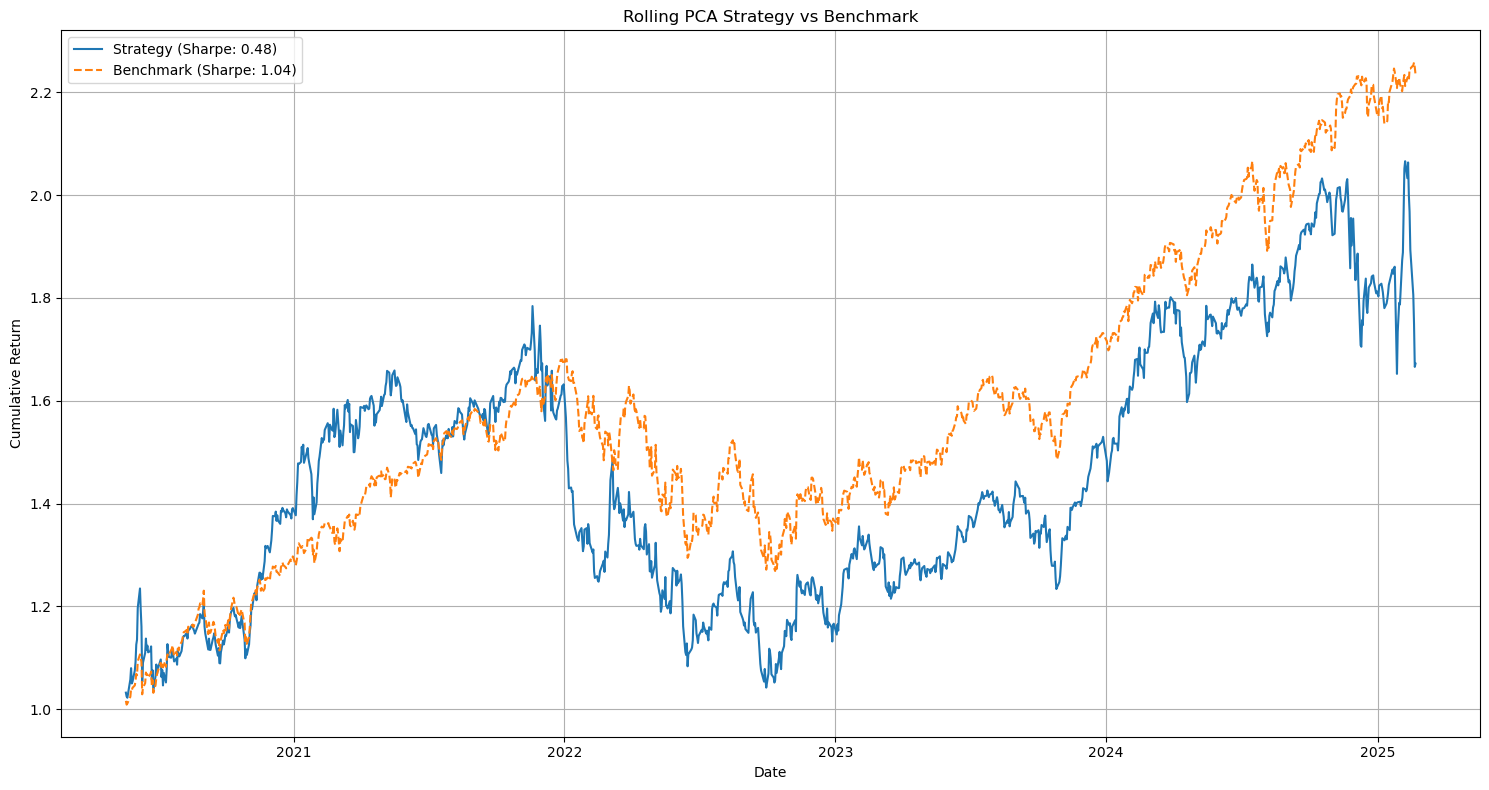

In [150]:
def rolling_pca_strategy(df, df_BM, rfr, lookback_days=252, holding_days=21, n_components=5):
    """Main strategy function"""
    # Initialize
    ret_df, ret_BM, rfr_aligned = calculate_returns(df, df_BM, rfr)
    strategy_returns = pd.Series(index=ret_df.index, dtype=float)
    selected_pcs_history = []
    
    # Get all dates
    all_dates = ret_df.index.tolist()
    current_idx = 0
    
    while current_idx < len(all_dates):
        start_date = all_dates[current_idx]
        
        # Define the window
        lookback_start_idx = max(0, current_idx - lookback_days)
        window_data = ret_df.iloc[lookback_start_idx:current_idx]
        
        if len(window_data) < 30:
            current_idx += holding_days
            continue
        
        window_rfr = rfr_aligned.loc[window_data.index].mean().values[0] / 252
        
        # Perform PCA
        pca_results, loadings = perform_pca_analysis(window_data, n_components)
        
        # Calculate PC performance
        pc_performance = calculate_pc_performance(window_data, loadings, window_rfr)
        
        # Select top PCs
        top_pcs = pc_performance.nlargest(n_components, 'Sharpe').index
        selected_pcs_history.append((start_date, top_pcs))
        
        # Define holding period
        hold_end_idx = min(current_idx + holding_days, len(all_dates))
        hold_dates = all_dates[current_idx:hold_end_idx]
        
        if len(hold_dates) == 0:
            break
        
        # Calculate portfolio returns
        holding_window = ret_df.loc[hold_dates]
        portfolio_weights = calculate_portfolio_weights(loadings, top_pcs)
        portfolio_returns = (holding_window * portfolio_weights).sum(axis=1)
        strategy_returns.loc[hold_dates] = portfolio_returns
        
        current_idx += holding_days
    
    # Calculate final performance metrics
    strategy_returns = strategy_returns.dropna()
    performance = calculate_performance_metrics(
        strategy_returns, 
        ret_BM.loc[strategy_returns.index],
        rfr_aligned.loc[strategy_returns.index].mean().values[0]
    )
    
    # Plot results
    fig, ax = plot_results(performance['strategy'], performance['benchmark'])
    
    return {
        'strategy_returns': strategy_returns,
        'benchmark_returns': ret_BM.loc[strategy_returns.index],
        'selected_pcs_history': selected_pcs_history,
        'performance_metrics': performance,
        'plot': (fig, ax)
    }


rfr = Get_rfr(valid_start_day)
results = rolling_pca_strategy(df, df_BM, rfr)
plt.show()

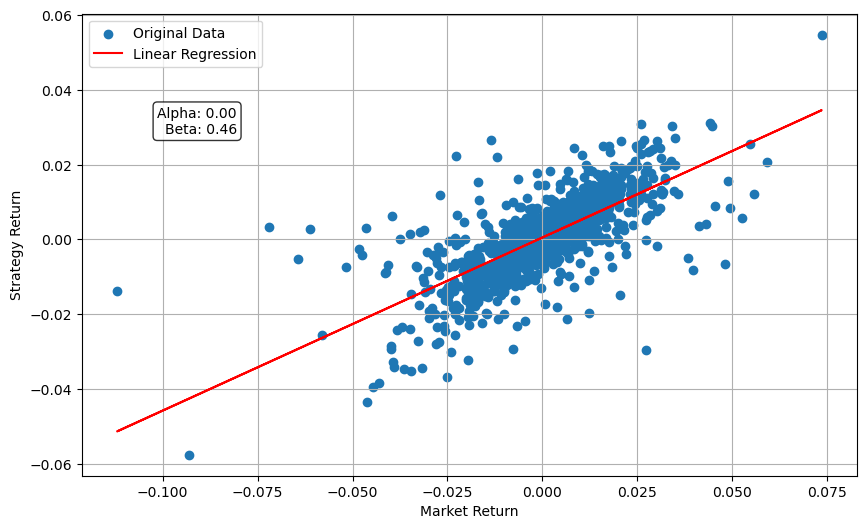

Alpha = 0.0, Beta = 0.463


In [151]:
BM_simple_return = results['performance_metrics']['benchmark']['returns'][index_banch_mart[0]].values
Str_simple_return = results['performance_metrics']['strategy']['returns'].values
import Functions.AlphaBeta as MT
plt.figure(figsize=(10, 6))
alpha, beta = MT.AlphaBeta(BM_simple_return,
                            Str_simple_return,
                            plot=True)
print(f'Alpha = {alpha}, Beta = {beta}')

In [152]:
metric = MT.downside_metrics(Str_simple_return, BM_simple_return)
for x in metric:
    print(f'{x}: {metric[x]}')

max_drawdown: -0.41593052526387253
max_drawdown_duration: 574
var_95: -0.02584255357758969
cvar_95: -0.03845100682232206
down_beta: 1.0318393392932106
